In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

/Users/anshul/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
subreddit = pd.read_csv('~/Documents/DSIR/Submissions/Projects/project_3/CSV-Data/subreddit.csv')

In [3]:
#I neglected to drop duplicates in the first EDA notebook, so let's do that first before we do anythign else:

subreddit.drop_duplicates(keep='last', inplace = True)

In [4]:
#In addition to NLTK's stopwords, there are other stopwords that I want to remove from our dataframe;
#I'm also going to remove any 'time-related' stopwords, such as day-of-week, month, time-of-day, as these are
#irrelevent to our model:

time_stopwords = ["monday", "tuesday", "wednesday", "thursday", "friday", "satudray", "sunday", 
                  "mon", "tues", "wed", "thurs", "fri", "sat", "sun", 
                  "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", 
                  "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec", 
                  "day", "week", "weekend", "month", "year",
                  "days", "weeks", "weekends", "months", "years"]

In [5]:
#Creating our CVEC for singlular words:

cvec_1 = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(time_stopwords),
                         min_df = 5,
                         ngram_range = (1, 1),
                         max_df = 50)

In [6]:
#Fitting and transforming data to CVEC:

terms_sub = cvec_1.fit_transform(subreddit['title_selftext'])

In [7]:
terms_sub_df = pd.DataFrame(terms_sub.toarray(), columns = cvec_1.get_feature_names())

In [8]:
#Let's create a boolean of our class columns:
# 1 = 'Futurology'
# 0 = 'AskScience'

subr = np.where(subreddit["subreddit"] == "Futurology", 1, 0)

In [9]:
#Inserting class columns into the terms_sub_df dataframe:

terms_sub_df.insert(0, 'target_subreddit', subr)

In [10]:
#Let's create a DF of the top 30 words in either subreddit:

top_words = terms_sub_df.groupby('target_subreddit').mean().T.sort_values(0, ascending = False).head(30)

In [11]:
top_words.head()

target_subreddit,0,1
sleep,0.009501,0.003686
object,0.008692,0.001433
earths,0.007681,0.002457
hair,0.007681,0.001024
eye,0.007479,0.004095


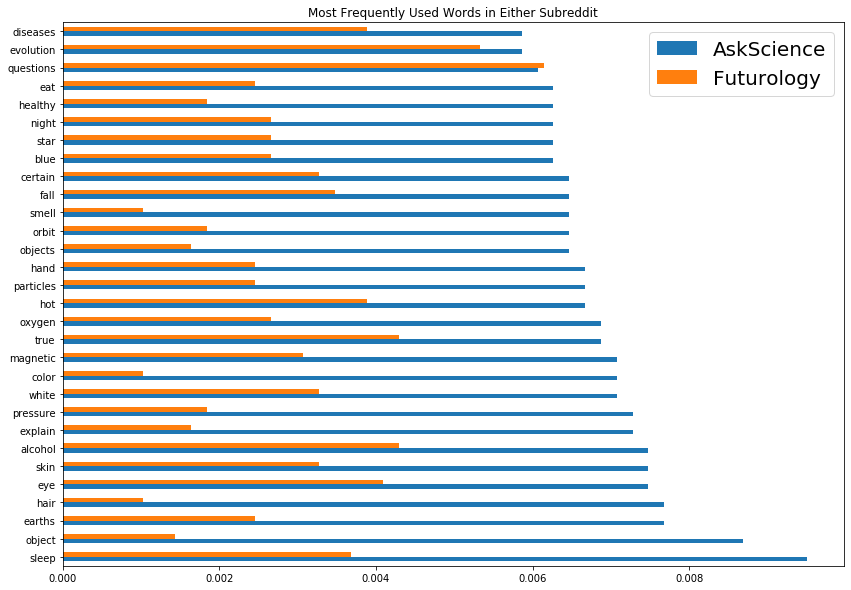

In [71]:
#Let's create a visualization of the top 20 words in either subreddit:

top_words.plot(y=[0, 1], kind="barh", figsize= (14,10))
plt.title("Most Frequently Used Words in Either Subreddit")
plt.legend(labels=["AskScience", "Futurology"], fontsize = 20);

In [13]:
#Now that we have the most commonly appearing words, let's take a look at the most common bigrams:

cvec_2 = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(time_stopwords),
                         min_df = 5,
                         ngram_range = (2, 3),
                         max_df = 50)

In [14]:
#Fitting and transforming:

terms_sub_2 = cvec_2.fit_transform(subreddit['title_selftext'])

In [15]:
#Let's create a DF:

terms_sub_df_2 = pd.DataFrame(terms_sub_2.toarray(), columns = cvec_2.get_feature_names())

In [16]:
#Instering the the class column again:

terms_sub_df_2.insert(0, 'target_subreddit', subr)

In [17]:
#Sorting by the top 30 bigrams:

top_bigrams = terms_sub_df_2.groupby('target_subreddit').mean().T.sort_values(0, ascending = False).head(20)

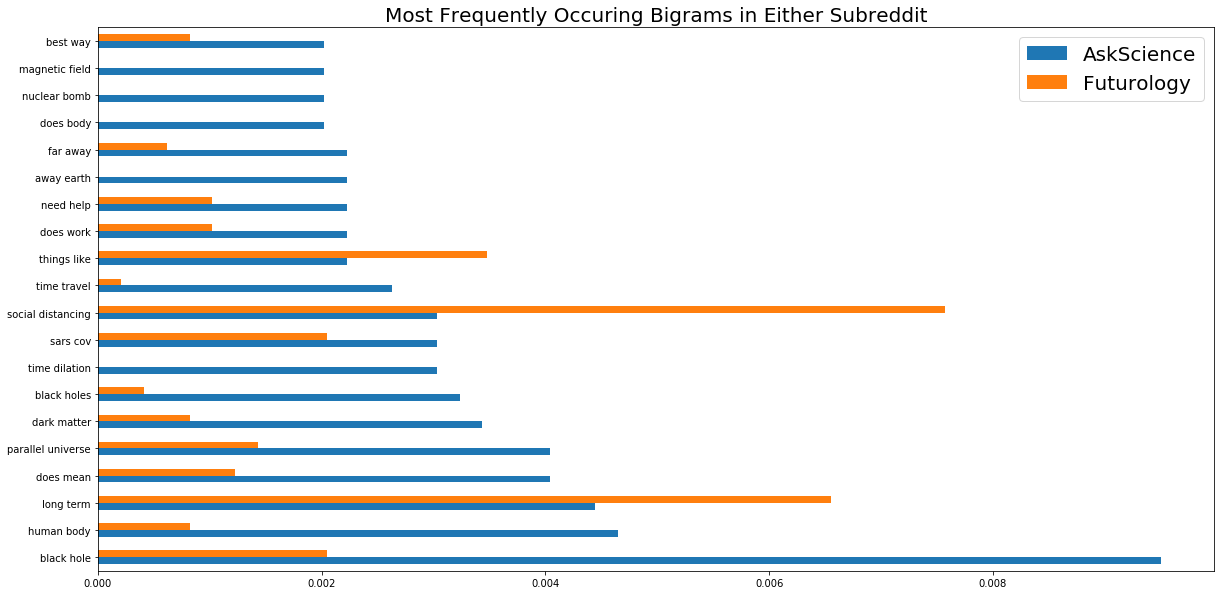

In [18]:
# Visualize the top words between each subreddit

top_bigrams.plot(y=[0, 1], kind="barh", figsize = (20,10))
plt.title("Most Frequently Occuring Bigrams in Either Subreddit", fontsize=20)
plt.legend(labels=["AskScience", "Futurology"], fontsize = 20);

## We begin modeling in the next section of the workbook:

In [19]:
#Creating a column for word counts:

subreddit['word_count'] = subreddit['title_selftext'].map(lambda x: len(x.split()))

In [20]:
#I learned how to use Sentiment Analyzer from YouTube:

si = SentimentIntensityAnalyzer()

In [21]:
#I'm creating a basic function to get the sentiment scores for a given post:

def get_sentiment(post):
    return si.polarity_scores(post)["compound"]

In [22]:
#Applying the function to the DF:

subreddit["sentiment"] = subreddit["title_selftext"].apply(get_sentiment)

In [23]:
subreddit.groupby("subreddit")["sentiment"].mean()

subreddit
Futurology    0.112918
askscience    0.028833
Name: sentiment, dtype: float64

## Stemming our Words!

In [24]:
#Instantiate our PorterStemmer

pstemmer = PorterStemmer()

In [25]:
#I Google'd how to apply to a PortStem to a column in Pandas for each word in that column, and this answer/code
#came from StackOverflow:

def stem_words(sentence):
    token = sentence.split() #Splits on each word in a sentence
    stem_tokens = [pstemmer.stem(i) for i in token]
    return ' '.join(stem_tokens)

subreddit["stem_words"] = subreddit["title_selftext"].apply(stem_words)

### At last, we can set up our X and y variables, and begin the modeling process

In [26]:
#Reminder:
# 1 = 'Futurology'
# 0 = 'AskScience'

subreddit["subreddit"] = np.where(subreddit["subreddit"] == "Futurology", 1, 0)

In [27]:
X = subreddit[["stem_words", "word_count", "sentiment"]]
y = subreddit["subreddit"]

In [28]:
#Splitting our data into train and test:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [29]:
y.value_counts(normalize = True)

0    0.503204
1    0.496796
Name: subreddit, dtype: float64

In [30]:
#Creating a function to return the columns that we want to use in our model:

text_data = FunctionTransformer(lambda x: x["stem_words"], validate = False)
numerica_data = FunctionTransformer(lambda x: x[["word_count", "sentiment"]], validate = False)

In [31]:
#We're going to model with Logistic Regression:

pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', numerica_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', text_data),
                ('tvec', TfidfVectorizer(ngram_range = (1, 2), stop_words = text.ENGLISH_STOP_WORDS.union(time_stopwords)))
            ]))
    ])),
    ('lr', LogisticRegression(penalty = "l2", C = 1, solver = "liblinear"))
])

params = {}

gs_pipeline = GridSearchCV(pipe, params, cv = 5)

In [32]:
gs_pipeline.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x1a2ced78c0>)),
                                                                                        ('ss',
                                                                                         StandardScaler())])),
                                                                       ('text_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x1a2ced77a0>)),
                                  

In [33]:
#Best estimator:

gs_best_model = gs_pipeline.best_estimator_

In [34]:
#Checking the scores on our train/test model:

print(gs_best_model.score(X_train, y_train))
print(gs_best_model.score(X_test, y_test))

0.9622948596229486
0.871440195280716


In [35]:
#Evaluating our model:
#Generating our predictions

y_preds = gs_best_model.predict(X_test)

In [36]:
#Creating a function to look at the coefficients 
#This is not my code, it was created as a collaboration with classmates Clint, Jason, Jonathan, and Daniel (especially Daniel):

def coef_scores(y_test, preds, classes):
    coef = confusion_matrix(y_test, preds)
    print(f'Accuracy: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(coef, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [37]:
coef_scores(y_test, y_preds, ['ShittyLifeProTips', 'LifeProTips'])

Accuracy: 0.871440195280716


,Predicted ShittyLifeProTips,Predicted LifeProTips
Actual ShittyLifeProTips,1088,149
Actual LifeProTips,167,1054


In [38]:
#Looking at the coefficients of our model:

coefs = gs_best_model.named_steps["lr"].coef_[0]

In [39]:
#Feature names:

features = ["word_count", "sentiment"]
features.extend(gs_best_model.named_steps['features'].transformer_list[1][1].named_steps['tvec'].get_feature_names())

In [40]:
#Just for visual clarity, I'm going to create a dataframe of our feature names and coefficients.
#This may be helpful for visualizations later for the presentation portion of the project:

coef_df = pd.DataFrame({'features' : features, "coeffs" : coefs, 'absolute_coefs': np.abs(coefs)})

In [41]:
coef_df.head()

,features,coeffs,absolute_coefs
0,word_count,1.173801,1.173801
1,sentiment,0.131361,0.131361
2,aa,-0.196364,0.196364
3,aa batteri,-0.143112,0.143112
4,aa meet,-0.062293,0.062293


In [42]:
coef_df.shape

(80829, 3)

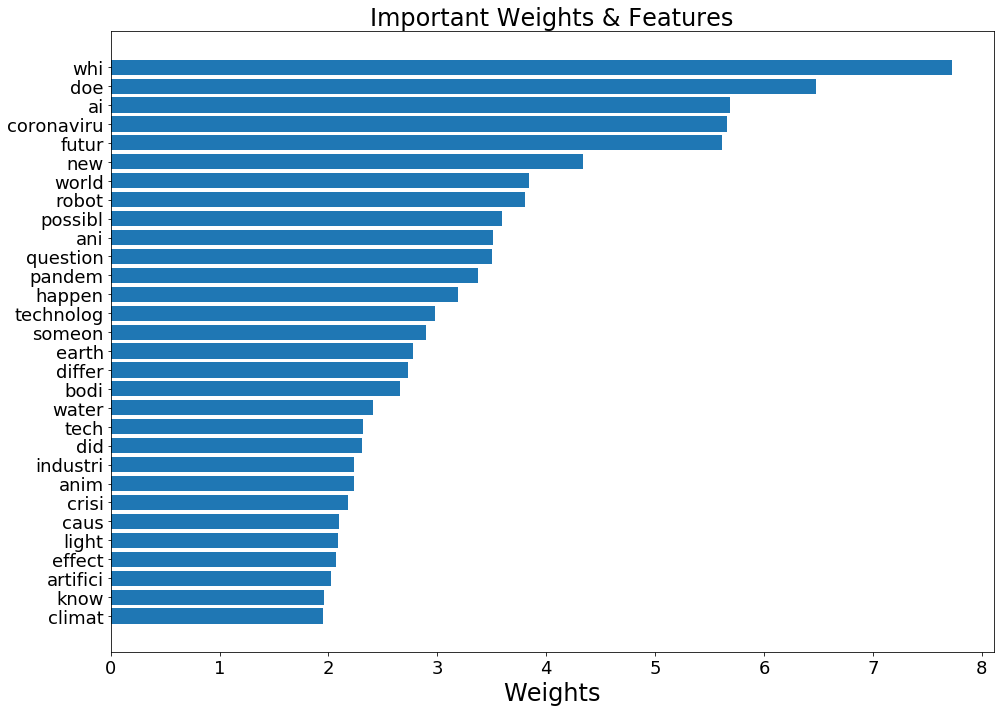

In [43]:
#Let's graph this to show the most important weights:

ex_df = coef_df.sort_values('absolute_coefs', ascending = False)
ex_df = ex_df.reset_index(drop = True)
ex_df = ex_df.set_index('features')
ex_df = ex_df[ex_df['absolute_coefs'] != 0] #We do not care about coefficients of 0
ex_df.head(20)
weights = ex_df['absolute_coefs'].head(30).sort_values()
labels = weights.index
plt.figure(figsize = (14, 10))
plt.barh(labels, weights)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlabel('Weights', fontsize = 24)
plt.title("Important Weights & Features", fontsize = 24)
plt.tight_layout();

In [44]:
#Modeling with Random Forest:

X = subreddit['stem_words']
y = subreddit['subreddit']

In [45]:
#Splitting again:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [46]:
#Instantiate our model:

rf = Pipeline([
    ("tvec", TfidfVectorizer()),
    ("rf",RandomForestClassifier(random_state = 42))])

In [47]:
#Hyperparameters:

rf_params = {
    "tvec__max_features": [500], # max features 100 and 500
    "tvec__ngram_range": [(1,2)], # ngram default and ngrams 2 and 3
    "tvec__stop_words": [text.ENGLISH_STOP_WORDS.union(time_stopwords)], 
    "rf__n_estimators": [125],
    "rf__max_depth": [6],
    "rf__max_features": ["auto"]
}

In [48]:
#Grid Searching:

rf_gs = GridSearchCV(
    rf, 
    param_grid = rf_params,
    cv = 5
)

In [49]:
#Fitting our model:

rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [6], 'rf__max_features': ['auto'],
                         'rf__n_estimators': [125], 'tvec__max_features': [500],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                            

In [50]:
#Saving our best model:

rf_best_model = rf_gs.best_estimator_

In [51]:
#Checking our scores:

print(rf_best_model.score(X_train, y_train))
print(rf_best_model.score(X_test, y_test))

0.7760748677607486
0.7697314890154597


In [52]:
#Multinomial Naive Bayes model:

cvec_4 = CountVectorizer()
mnb = MultinomialNB()

In [53]:
train_data_features_4 = cvec_4.fit_transform(X_train)

In [54]:
test_data_features_4 = cvec_4.transform(X_test)

In [55]:
#Fitting our Multinomial NB to our data:

mnb.fit(train_data_features_4, y_train)

MultinomialNB()

In [56]:
print(mnb.score(train_data_features_4, y_train))
print(mnb.score(test_data_features_4, y_test))

0.9305574393055744
0.871440195280716
